In [55]:
%pip install tensorflow numpy matplotlib scikit-learn pandas

In [56]:
# %pip uninstall tensorflow

## Import Library

In [58]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image as imageTf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
from keras import Sequential, layers
from tensorflow.keras.optimizers import AdamW
from keras.applications import VGG16
from tensorflow.keras.layers import Dense, LeakyReLU
from keras.regularizers import l2
from keras.optimizers import Adam
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [59]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [60]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


## Set Variables

In [61]:
train_dir = 'dataset/train'
val_dir = 'dataset/valid'
test_dir = 'dataset/test'

image_size = 64
batch_size = 32
epoch = 15

## Spliting Dataset

In [62]:
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 4819 files belonging to 11 classes.
Found 1367 files belonging to 11 classes.
Found 681 files belonging to 11 classes.


## Normalize Input

In [63]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# train_dataset = train_dataset.map(lambda x, y: (x, y))
# val_dataset = val_dataset.map(lambda x, y: (x, y))
# test_dataset = test_dataset.map(lambda x, y: (x, y))


In [64]:
class_names = os.listdir(train_dir)

class_names = [name for name in class_names if os.path.isdir(os.path.join(train_dir, name))]

class_names.sort()

print(class_names)

[' alluvial', ' black', ' cinder', ' clay', ' laterite', ' loamy', ' peat', ' red', ' sandy', ' sandy_loam', ' yellow']


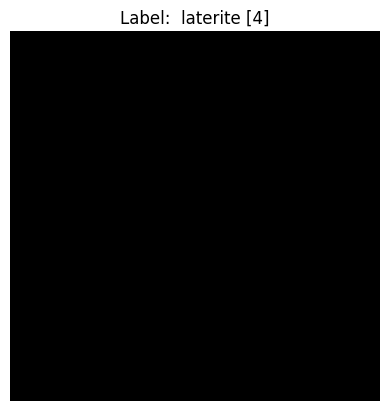

Label: 4 -> Class Name:  laterite


In [65]:
for images, labels in train_dataset.take(1):
    image = images[0].numpy()
    label = labels[0].numpy()

    class_name = class_names[label]

    # Plot the image
    plt.imshow(image.astype("uint8"))
    plt.title(f"Label: {class_name} [{label}]")
    plt.axis('off')
    plt.show()

    print(f"Label: {label} -> Class Name: {class_name}")

In [66]:
# vgg16_base = VGG16(
#     include_top=False,  # Exclude the default classifier head
#     weights="imagenet",  # Use ImageNet weights
#     input_shape=(image_size, image_size, 3),  # Input shape
#     pooling="avg"  # Global average pooling for feature extraction
# )

# # Freeze the pre-trained base to retain its weights during training
# vgg16_base.trainable = False

## Creating Model

In [67]:
model = Sequential([
    layers.Input(shape=(image_size, image_size, 3)),

    # layers.Conv2D(64, (3, 3), activation='elu', kernel_regularizer=l2(0.01)),
    layers.Conv2D(64, (3, 3), activation='elu'),
    layers.BatchNormalization(),  # Add BatchNorm
    layers.MaxPooling2D(2, 2),

    # layers.Conv2D(32, (3, 3), activation='elu', kernel_regularizer=l2(0.01)),
    layers.Conv2D(32, (3, 3), activation='elu'),
    layers.BatchNormalization(),  # Add BatchNorm
    layers.MaxPooling2D(2, 2),

    # layers.Conv2D(16, (3, 3), activation='elu', kernel_regularizer=l2(0.01)),
    layers.Conv2D(16, (3, 3), activation='elu'),
    layers.BatchNormalization(),  # Add BatchNorm
    layers.MaxPooling2D(2, 2),

    # layers.GlobalAveragePooling2D(),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(68, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),  # Add BatchNorm

    layers.Dense(11, activation='softmax')
])

optimizer = Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [68]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 29, 29, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 29, 29, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 12, 12, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 68)                  │           8,772 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 11)                  │             363 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,655 (432.25 KB)

 Trainable params: 110,367 (431.12 KB)

 Non-trainable params: 288 (1.12 KB)

In [69]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr * 1.1
    elif epoch % 10 == 0:
        return lr * 0.5
    return lr

In [70]:
# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
# )

In [71]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Training Model

In [72]:
history = model.fit(
    train_dataset,
    epochs=epoch,
    validation_data=val_dataset,
    callbacks=[lr_scheduler]
)

Epoch 1/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 143s 544ms/step - accuracy: 0.3670 - loss: 1.9068 - val_accuracy: 0.1353 - val_loss: 2.3221 - learning_rate: 1.1000e-04
Epoch 2/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 135s 505ms/step - accuracy: 0.6194 - loss: 1.2937 - val_accuracy: 0.2451 - val_loss: 2.0013 - learning_rate: 1.2100e-04
Epoch 3/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 86s 527ms/step - accuracy: 0.6757 - loss: 1.1299 - val_accuracy: 0.6657 - val_loss: 1.3045 - learning_rate: 1.3310e-04
Epoch 4/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 78s 513ms/step - accuracy: 0.7124 - loss: 1.0006 - val_accuracy: 0.7732 - val_loss: 0.8741 - learning_rate: 1.3310e-04
Epoch 5/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 85s 533ms/step - accuracy: 0.7324 - loss: 0.9206 - val_accuracy: 0.8025 - val_loss: 0.7084 - learning_rate: 1.3310e-04
Epoch 6/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 79s 514ms/step - accuracy: 0.7548 - loss: 0.8510 - val_accuracy: 0.8237 - val_loss: 0.6216 - learning_rate: 1.3310e-04
Epoch 7/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 78s 

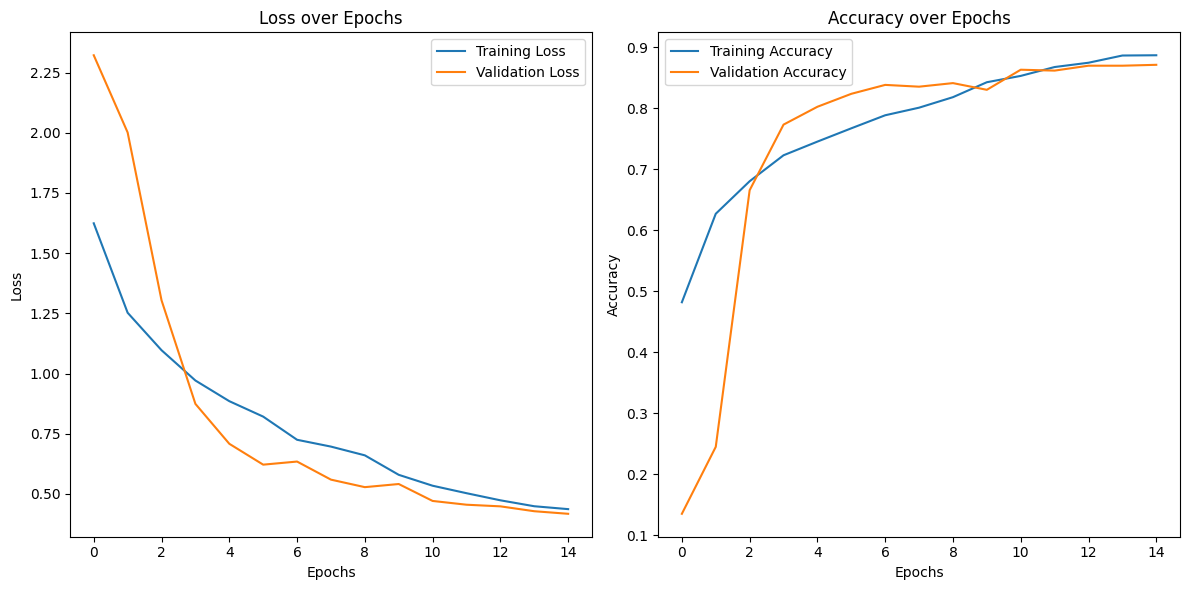

In [73]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Test Prediction

In [48]:
img_path = 'test/cinder.jpg'

img = imageTf.load_img(img_path, target_size=(224, 224))

img_array = imageTf.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

FileNotFoundError: [Errno 2] No such file or directory: 'test/cinder.jpg'

In [ ]:
predictions = model.predict(img_array)

In [ ]:
predicted_class = np.argmax(predictions, axis=-1)

## Converting Model

In [ ]:
!pip install tensorflowjs

In [74]:
model.save("model.h5")

In [ ]:
!tensorflowjs_converter --help

In [75]:
!tensorflowjs_converter --input_format=keras model.h5 ./

2024-12-12 09:56:24.111377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733997384.143960   71204 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733997384.153840   71204 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class} {class_names[predicted_class[0]]}')
plt.show()

In [ ]:
# save modal
model.save("model.h5")
model.save("saved_model/my_model")

In [ ]:
# load model
# from tensorflow.keras.models import load_model

# model = load_model("model.h5")

In [76]:
import tensorflow as tf
keras_model = tf.keras.models.load_model('model.h5')

In [77]:
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpm9c2j7ch'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  137372752450784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137375562424640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137372754310800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137372754306048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137372754312032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137372754311328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137372728415632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137372728415104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137372728425312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137372728419680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13737272841633

In [78]:
with open('converted_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [79]:
pip install tflite-support-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


In [3]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

In [4]:
ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = "converted_model.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "label.txt"
_SAVE_TO_PATH = "converted_model_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba